# BAT TTE Imaging Analysis Overview

## This notebook gives a brief overview of the capabilities of the BatAnalysis package to dynamically analyze BAT Time-tagged Event (TTE) data as it relates to the imaging capabilities of BAT. 

## Installation instructions for Beta testers:

Thanks to all who are willing to test the TTE portion of BatAnalysis. Here are some quick instructions for getting the code and installing it for access in python:
- `git clone -b TTE_analysis https://github.com/parsotat/BatAnalysis.git`
- `cd BatAnalysis`
- if BatAnalysis is already installed: `pip uninstall BatAnalysis`
- `pip install -e .`

Then in a jupyter notebook or an ipython session `import batanalysis as ba` should work.

Any issues that get brought up will be pushed to the github branch. To get these changes simply do `git pull` in the BatAnalysis directory and the next time you do `import batanalysis as ba` the changes will be implemented.

Here, we will analyze a BAT triggered GRB to exhibit the various capabilities that the BatAnalysis tool offers to interact with the TTE data, allowing users to download data, create sky images at any arbitrary time bin with any energy binning. 

Once again, we will look at GRB 211211A, a bright long GRB that was determined to be from a merger of compact objects. This GRB was detected by BAT and the refined analyses can be found here: https://swift.gsfc.nasa.gov/results/batgrbcat/GRB211211A/web/GRB211211A.html

Lets start off by importing the necessary python packages. 

In [1]:
import batanalysis as ba
from swifttools.swift_too import ObsQuery 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

### 1. Download the data

First, lets download the BAT TTE data for this event. We will use the basics of downloading Swift BAT data covered in the **Example_data_download** notebook in this directory. 

We will use the swifttools package to query over the hour that the GRB has occured to get the observations that have occured. We expect the GRB to appear here since we know that the GRB occured on 2021-12-11 with the trigger time of 13:09:59.634260 UTC. 

Documentation for swifttools can be found here: https://www.swift.psu.edu/too_api/

If you recently ran the **Example_TTE_rate_data_analysis** notebook in this directory then this directory will still exist and nothing will actually be downloaded.


In [2]:
tstart=Time("2021-12-11T13:00:00")
tend=Time("2021-12-11T14:00:00")

obs_table=ObsQuery(begin=tstart, end=tend)
print(obs_table)

+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
|          Begin Time |            End Time |          Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
| 2021-12-11 12:57:02 | 2021-12-11 13:10:36 |              Mrk 279 |        00037591121 |          685 |          129 |
| 2021-12-11 13:10:37 | 2021-12-11 13:15:21 |          GRB 211211A |        01088940000 |          215 |           69 |
| 2021-12-11 13:15:26 | 2021-12-11 13:28:00 |        CYGNUSCOCOON2 |        00095933007 |          630 |          124 |
| 2021-12-11 13:28:02 | 2021-12-11 13:52:57 | XMM_J004855.5-734946 |        00034599017 |         1310 |          185 |
| 2021-12-11 13:53:02 | 2021-12-11 13:57:59 |           SN2021aefx |        00014916016 |          235 |           62 |
| 2021-12-11 13:58:03 | 2021-12-11 14:06

Lets programatically select this observation and download all the data in the bat and auxil directories to a temporary directory. 

In [5]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

grb_obs=[i for i in obs_table if "GRB" in i.targname]
download = ba.download_swiftdata(grb_obs, quiet=False)

datadir=ba.datadir().joinpath(grb_obs[0].obsid)

print(download)
print(ba.datadir())

{'01088940000': {'obsid': '01088940000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/01088940000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='01088940000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}
/private/tmp/batdata/download_examples


Lets take a look at the files that we have downloaded. 

In [4]:
download[grb_obs[0].obsid]["data"]

01088940000/auxil,SWIFT_TLE_ARCHIVE.txt.21353.74897066.gz,Auxillary TLE file
'',sw01088940000pat.fits.gz,Auxillary attitude file
'',sw01088940000pjb.par.gz,Auxillary file
'',sw01088940000pob.cat.gz,Auxillary catalog
'',sw01088940000ppr.par.gz,Auxillary file
'',sw01088940000s.mkf.gz,Auxillary file
'',sw01088940000sao.fits.gz,Auxillary file
'',sw01088940000sat.fits.gz,Auxillary attitude file
'',sw01088940000sen.hk.gz,Auxillary housekeeping
'',sw01088940000sti.fits.gz,Auxillary file
'',sw01088940000uat.fits.gz,Auxillary attitude file


As is shown above, we have: 
 - the auxil directory with information related to the spacecraft, 
 - the tdrss directory with information related to the tdrss downlinked information for the GRB when it triggered BAT, 
 - the rate directory which holds hardware rate information, 
 - the event directory with the TTE data
 - the housekeeping directory with information related to the BAT instrument itself
 - the masktag directory with the Swift Data Center (SDC) precomputed coded mask weights for the GRB
 - the products directory with SDC precomputed lightcurves at various time/energy binnings, pha files at predetermined timebins, and sky images
 - the survey directory which holds BAT survey data associated with this observation, which can be analyzed following the **Example_Survey_Data_Analysis** notebook
 
 In this notebook, we will focus on the imaging capability and better understand how we can interact with and reproduce the precomputed detector plane histograms (DPHs), the Detector Plane Images (DPIs), and sky image files from the SDC, and how we can construct new sky image files and access the relevant data. We will additionally delve into mosaicing (adding these images) and source detection. 

### 2. Loading the precomputed Detector Plane Histograms (DPHs)

The DPHs are not an integral part of imaging analyses with BAT, however they provide a useful introduction to ways that we will interact with the other BAT data products. 

DPHs are simply histograms of the TTE data binned in space (by detector) and time. The BatAnalysis class that handles this is called `BatDPH` which inherits many properties from the `Histogram` class that is available through the [histpy](https://histpy.readthedocs.io/en/latest/tutorials/quick-start.html#) python package. 

There are many intuitive things that we can do with this BatDPH object. To show some of these aspect, lets start by first loading in a precomputed DPH from the data that we have downloaded for GRB 211211A. To do this we simply use the `from_file` class method. 

In [6]:
dph=ba.BatDPH.from_file(datadir.joinpath("bat/survey").joinpath("sw01088940000bsvabo27acg0859.dph.gz"))

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_dph.py:198: UserWarning: No event file has been specified. The resulting DPH object will not be able to be arbitrarily modified either by rebinning in energy or time.


We can easily plot the DPH to take a look at it:

(<Figure size 640x480 with 2 Axes>, <Axes: >)

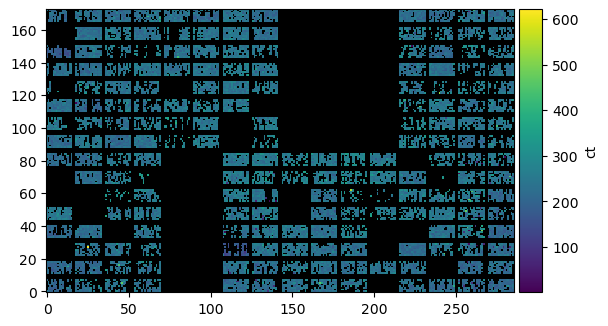

In [8]:
dph.plot()